# Semantic Segmentation Using U-Net

In [1]:
import os

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torchvision import transforms, io
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else (
        "cuda"
        if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available() else "cpu"
    )
)
print(device)

cuda


## Downloading Dataset

In [3]:
!kaggle datasets download -d mojtabanafez/self-driving-car-dataset-ai-course

Dataset URL: https://www.kaggle.com/datasets/mojtabanafez/self-driving-car-dataset-ai-course
License(s): Apache 2.0
 99%|███████████████████████████████████████▋| 516M/519M [00:26<00:00, 23.7MB/s]
100%|████████████████████████████████████████| 519M/519M [00:26<00:00, 20.4MB/s]


In [4]:
!mv /kaggle/working/self-driving-car-dataset-ai-course.zip /kaggle/working/Files.zip

In [5]:
!unzip Files.zip > out.txt

In [6]:
path = "" # Path to the root folder
image_path = os.path.join(path, "Files/data/CameraRGB/")
mask_path = os.path.join(path, "Files/data/CameraMask/")
image_list = sorted(os.listdir(image_path))
mask_list = sorted(os.listdir(mask_path))
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

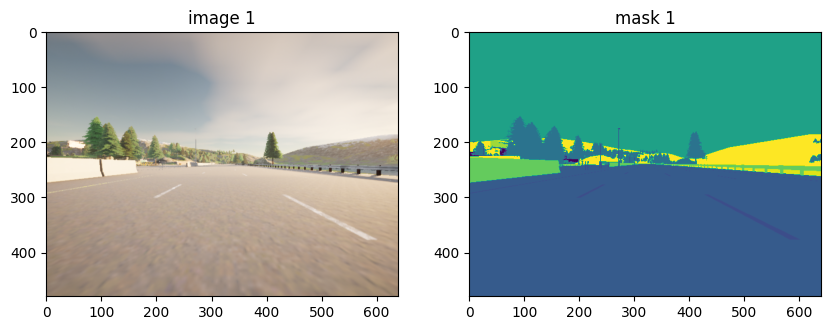

In [7]:
N = 1

img = [Image.open(image_list[i]) for i in range(N)]
mask = [np.array(Image.open(mask_list[i])) for i in range(N)]

plt.subplots(N, 2, figsize=(10, N*5))
for i in range(N):
    plt.subplot(N, 2, i * 2 + 1)
    plt.title(f'image {i + 1}')
    plt.imshow(img[i])
    
    plt.subplot(N, 2, i * 2 + 2)
    plt.title(f'mask {i + 1}')
    plt.imshow(mask[i][:,:,0])

## Preprocess the Data


In [8]:
class Segmentation_Dataset(Dataset):
    def __init__(self, ImagesDirectory, MasksDirectory):
        super(Segmentation_Dataset, self).__init__()

        self.image_files = ImagesDirectory
        self.mask_files = MasksDirectory
        
        self.images = []
        self.masks = []
        for i in range(len(self.image_files)):
            image_path = os.path.join(self.image_files[i])
            mask_path = os.path.join(self.mask_files[i])

            self.images.append(Image.open(image_path))
            self.masks.append(Image.open(mask_path))
            
        self.mask_transforms = transforms.Compose(
            [
                transforms.Resize((192, 256)),
                transforms.PILToTensor(),
                transforms.Lambda(lambda x : x[0])
            ]
        )
        self.image_transforms = transforms.Compose(
            [
                transforms.Resize((192, 256)),
                transforms.ToTensor(),
                transforms.Lambda(lambda x : x[:3]),
                transforms.Normalize([0.485, 0.456, 0.406],
                     [0.229, 0.224, 0.225]),
            ]
        )

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        
        image = self.images[index]
        mask = self.masks[index]

        image = self.image_transforms(image)
        mask = self.mask_transforms(mask)

        return image, mask


In [9]:
def plot_item(image, mask):
    image_np = image.cpu().numpy().transpose((1,2,0))
    mask_np = mask.cpu().numpy()
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image_np)
    axes[0].set_title("Image")
    axes[0].axis('off')

    axes[1].imshow(mask_np)
    axes[1].set_title("Mask")
    axes[1].axis('off')

    plt.show()

In [10]:
BATCH_SIZE = 16

train_image, test_image, train_mask, test_mask = train_test_split(image_list, mask_list, test_size=0.15, random_state=42)
train_image, val_image, train_mask, val_mask = train_test_split(train_image, train_mask, test_size=0.1, random_state=42)

train_dataset = Segmentation_Dataset(train_image, train_mask)
val_dataset = Segmentation_Dataset(val_image, val_mask)
test_dataset = Segmentation_Dataset(test_image, test_mask)

train_dataloader=DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader=DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader=DataLoader(test_dataset, batch_size=BATCH_SIZE)

## U-net model Architecture

In [11]:
class conv_block(nn.Module):
    def __init__(self, in_ch, n_filters=32, dropout_prob=0, max_pooling=True):

        super().__init__()

        self.max_pooling = max_pooling
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, n_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),
        )
        self.pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):

        skip_connection = self.convs(x)
        next_layer = self.pooling_layer(skip_connection) if self.max_pooling else skip_connection

        return next_layer, skip_connection

In [12]:
class upsampling_block(nn.Module):
    def __init__(self, in_ch, skip_ch, n_filters=32):
        super().__init__()
        
        self.up_conv = nn.ConvTranspose2d(in_ch, n_filters, kernel_size=2, stride = 2)
        self.convs = nn.Sequential(
            nn.Conv2d(n_filters + skip_ch, n_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(inplace=True),
        )

    def forward(self, expansive_input, contractive_input):

        up_conved = self.up_conv(expansive_input)
        cat_inputs = torch.cat((contractive_input, up_conved), dim = 1)
        conv = self.convs(cat_inputs)

        return conv

In [13]:
class UNet(nn.Module):
    def __init__(self, in_ch=3, n_filters=32, n_classes=23):
        super().__init__()
        
        # Down-sampling
        self.encoder1 = conv_block(in_ch = in_ch, n_filters = n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder2 = conv_block(in_ch = n_filters, n_filters = 2 * n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder3 = conv_block(in_ch = 2 * n_filters, n_filters = 4 * n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder4 = conv_block(in_ch = 4 * n_filters, n_filters = 8 * n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder5 = conv_block(in_ch = 8 * n_filters, n_filters = 16 * n_filters, dropout_prob = 0, max_pooling=False)
            
        # Up-sampling and final layer
        self.decoder4 = upsampling_block(in_ch = 16 * n_filters, skip_ch = 8 * n_filters, n_filters = 8 * n_filters)
        self.decoder3 = upsampling_block(in_ch = 8 * n_filters, skip_ch = 4 * n_filters, n_filters = 4 * n_filters)
        self.decoder2 = upsampling_block(in_ch = 4 * n_filters, skip_ch = 2 * n_filters, n_filters = 2 * n_filters)
        self.decoder1 = upsampling_block(in_ch = 2 * n_filters, skip_ch = n_filters, n_filters = n_filters)
        
        self.final_layer = nn.Conv2d(n_filters, n_classes, kernel_size=1)

    def forward(self, x):
        next_layer1, skip_connection1 = self.encoder1(x)
        next_layer2, skip_connection2 = self.encoder2(next_layer1)
        next_layer3, skip_connection3 = self.encoder3(next_layer2)
        next_layer4, skip_connection4 = self.encoder4(next_layer3)
        next_layer5, _ = self.encoder5(next_layer4)
        
        next_layer6 = self.decoder4(next_layer5, skip_connection4)
        next_layer7 = self.decoder3(next_layer6, skip_connection3)
        next_layer8 = self.decoder2(next_layer7, skip_connection2)
        next_layer9 = self.decoder1(next_layer8, skip_connection1)
        
        out = self.final_layer(next_layer9)

        return out

In [14]:
unet = UNet().to(device)

## Training the model

In [15]:
EPOCHS = 50
LR = 0.001
B1 = 0.9
B2 = 0.999

In [16]:
criterion=nn.CrossEntropyLoss()

In [17]:
optimizer=torch.optim.Adam(unet.parameters(), 
                           lr = LR, 
                           betas = (B1, B2))

In [18]:
for epoch in range(EPOCHS):
    epoch_losses = []

    for image, mask in train_dataloader:
        image = image.to(device)
        mask = mask.to(device)

        mask_pred = unet(image)
        
        optimizer.zero_grad()
        loss = criterion(mask_pred, mask.long())
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        
    val_losses = []
    with torch.no_grad():
        for image, mask in val_dataloader:
            image = image.to(device)
            mask = mask.to(device)

            mask_pred = unet(image)

            loss = criterion(mask_pred, mask.long())

            val_losses.append(loss.item())

    
    mean_loss = np.mean(epoch_losses)
    val_mean_loss = np.mean(val_losses)
    print(f"EPOCH#{epoch:2d},\t Train_Loss:{mean_loss:8.6f} \t Val_Loss:{val_mean_loss:8.6f}")

EPOCH# 0,	 Train_Loss:1.778446 	 Val_Loss:1.157516
EPOCH# 1,	 Train_Loss:0.917321 	 Val_Loss:0.736153
EPOCH# 2,	 Train_Loss:0.644257 	 Val_Loss:0.566282
EPOCH# 3,	 Train_Loss:0.527775 	 Val_Loss:0.477214
EPOCH# 4,	 Train_Loss:0.452805 	 Val_Loss:0.417055
EPOCH# 5,	 Train_Loss:0.394073 	 Val_Loss:0.368738
EPOCH# 6,	 Train_Loss:0.352213 	 Val_Loss:0.343859
EPOCH# 7,	 Train_Loss:0.340029 	 Val_Loss:0.320950
EPOCH# 8,	 Train_Loss:0.324886 	 Val_Loss:0.299302
EPOCH# 9,	 Train_Loss:0.315829 	 Val_Loss:0.296203
EPOCH#10,	 Train_Loss:0.284131 	 Val_Loss:0.270703
EPOCH#11,	 Train_Loss:0.264884 	 Val_Loss:0.254249
EPOCH#12,	 Train_Loss:0.252911 	 Val_Loss:0.255505
EPOCH#13,	 Train_Loss:0.249976 	 Val_Loss:0.248653
EPOCH#14,	 Train_Loss:0.239328 	 Val_Loss:0.230827
EPOCH#15,	 Train_Loss:0.259589 	 Val_Loss:0.275435
EPOCH#16,	 Train_Loss:0.265303 	 Val_Loss:0.238405
EPOCH#17,	 Train_Loss:0.226652 	 Val_Loss:0.227423
EPOCH#18,	 Train_Loss:0.216724 	 Val_Loss:0.214759
EPOCH#19,	 Train_Loss:0.207472 

## Visualize predictions

In [19]:
def create_mask(pred_mask):
    pred_mask = torch.argmax(pred_mask, dim=1)
    return pred_mask

In [20]:
def show_predictions(model, dataloader, device, num=1):
    
    plt.subplots(num, 3, figsize=(15, 5 * num))
    
    images, masks = next(iter(dataloader))

    images = images.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        model_predictions = model(images)
        preds = create_mask(model_predictions)

    for i in range(num):
        plt.subplot(num, 3, 3 * i + 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0))
        plt.title(f'image {i + 1}')

        plt.subplot(num, 3, 3 * i + 2)
        plt.imshow(masks[i].cpu())
        plt.title(f'true mask {i + 1}')

        plt.subplot(num, 3, 3 * i + 3)
        plt.imshow(preds[i].cpu())
        plt.title(f'predicted mask {i + 1}')

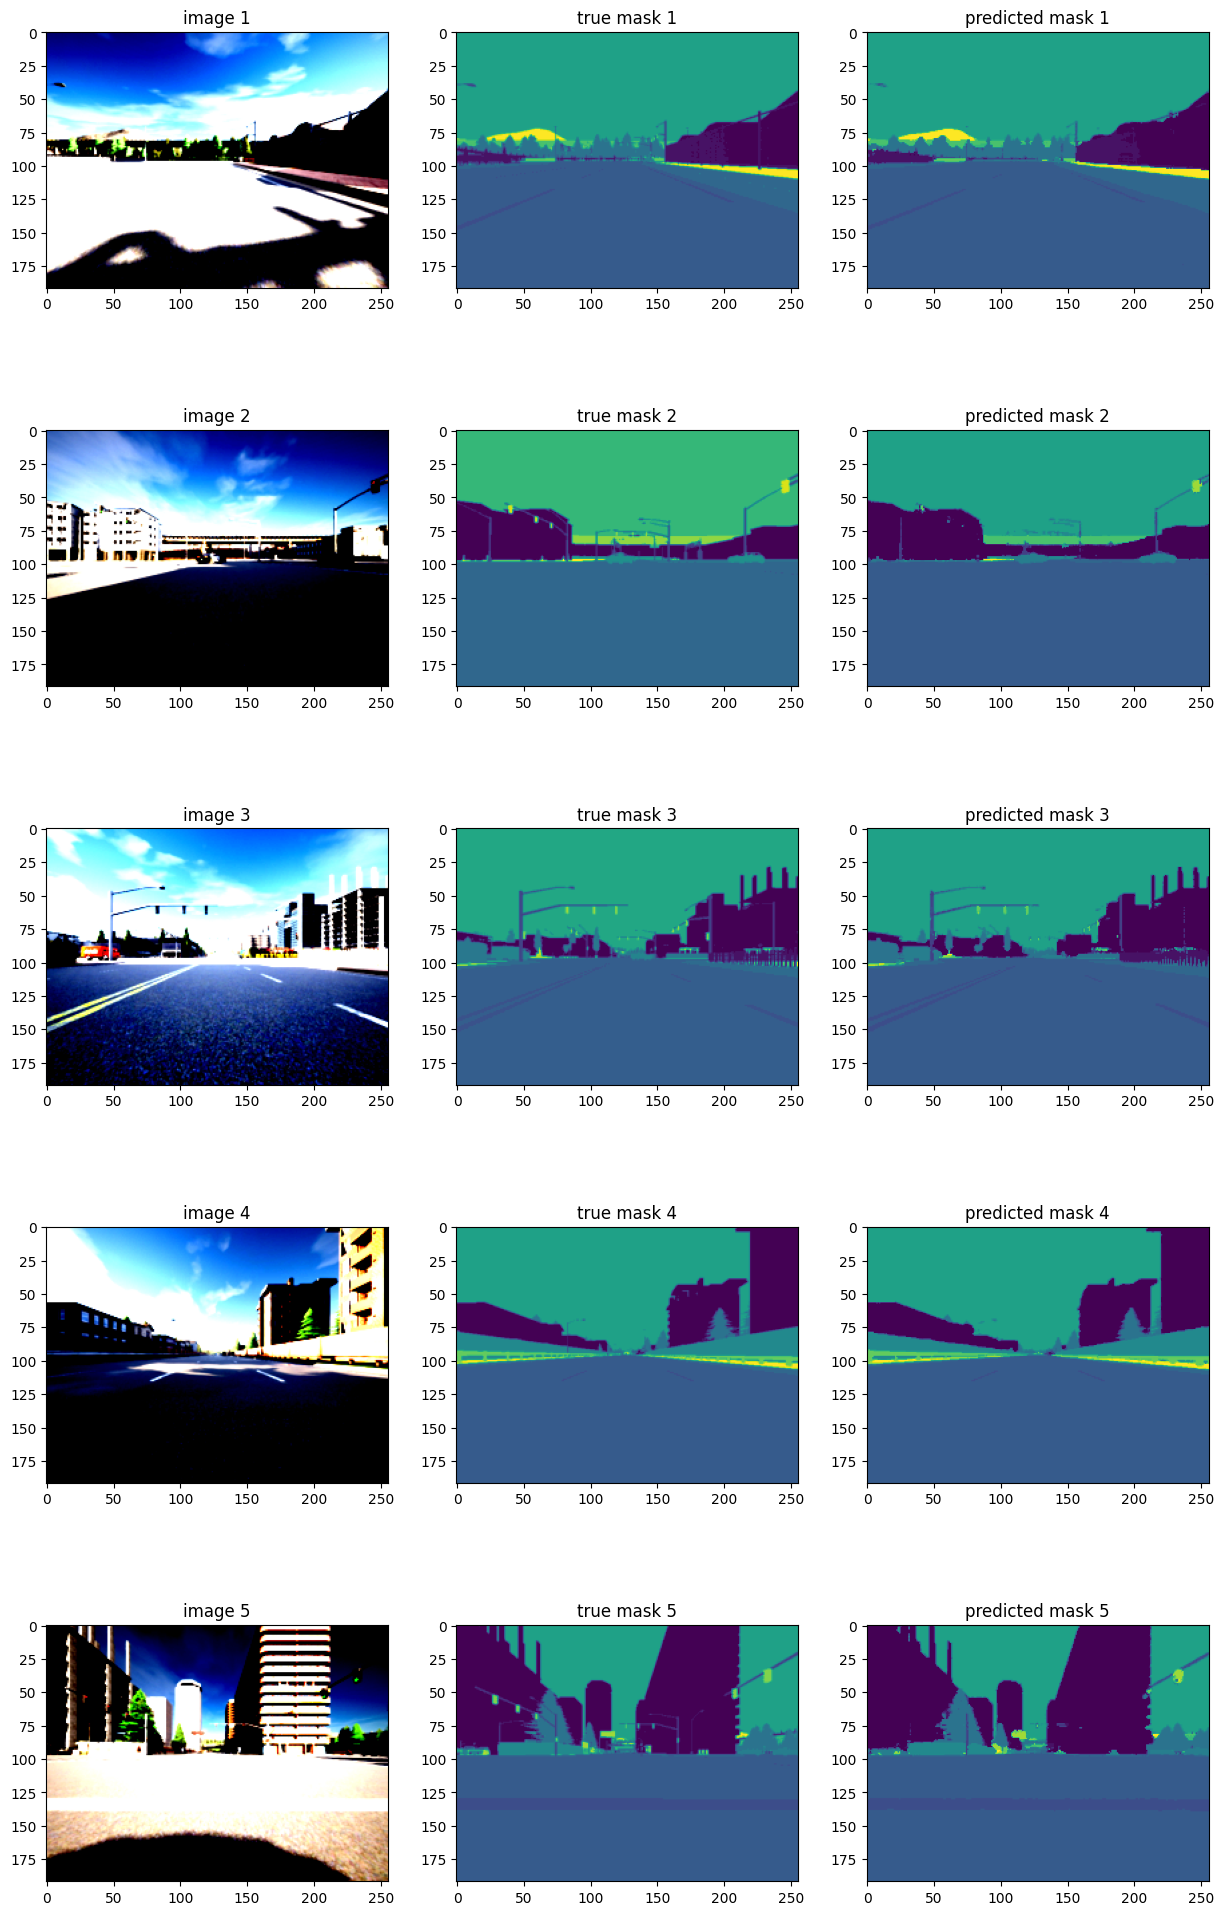

In [21]:
show_predictions(unet, val_dataloader, device, 5)

## Attention UNet model

In [22]:
class AttentionBlock(nn.Module):
    def __init__(self, F_l, F_int, F_g):
        super(AttentionBlock, self).__init__()
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=3, stride = 2, padding = 1),
            nn.BatchNorm2d(F_int),
        )
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int),
        )
        
        self.relu = nn.ReLU(inplace=True)
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int),
        )
        
        self.sigmoid = nn.Sigmoid()
        self.upsample = nn.ConvTranspose2d(F_int, F_l, kernel_size=2, stride = 2)

    def forward(self, x, g):
                
        x_out = self.W_x(x)
        g_out = self.W_g(g)
        relu_out = self.relu(x_out + g_out)
        psi = self.psi(relu_out)
        sig_out = self.sigmoid(psi)
        resampled = self.upsample(sig_out)
        
        return x * resampled

In [23]:
class UNet_With_Attention(nn.Module):
    def __init__(self, in_ch=3, n_filters = 32, n_classes = 23):

        super().__init__()
        
        # Down-sampling
        self.encoder1 = conv_block(in_ch = in_ch, n_filters = n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder2 = conv_block(in_ch = n_filters, n_filters = 2 * n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder3 = conv_block(in_ch = 2 * n_filters, n_filters = 4 * n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder4 = conv_block(in_ch = 4 * n_filters, n_filters = 8 * n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder5 = conv_block(in_ch = 8 * n_filters, n_filters = 16 * n_filters, dropout_prob = 0, max_pooling=False)
            
        # Up-sampling and final layer
        self.decoder4 = upsampling_block(in_ch = 16 * n_filters, skip_ch = 8 * n_filters, n_filters = 8 * n_filters)
        self.decoder3 = upsampling_block(in_ch = 8 * n_filters, skip_ch = 4 * n_filters, n_filters = 4 * n_filters)
        self.decoder2 = upsampling_block(in_ch = 4 * n_filters, skip_ch = 2 * n_filters, n_filters = 2 * n_filters)
        self.decoder1 = upsampling_block(in_ch = 2 * n_filters, skip_ch = n_filters, n_filters = n_filters)
        
        self.final_layer = nn.Conv2d(n_filters, n_classes, kernel_size=1)
        
        # Attention Gates
        self.attention4 = AttentionBlock(F_l = 8 * n_filters, F_int = 8 * n_filters, F_g = 16 * n_filters)
        self.attention3 = AttentionBlock(F_l = 4 * n_filters, F_int = 4 * n_filters, F_g = 8 * n_filters)
        self.attention2 = AttentionBlock(F_l = 2 * n_filters, F_int = 2 * n_filters, F_g = 4 * n_filters)
        self.attention1 = AttentionBlock(F_l = n_filters, F_int = n_filters, F_g = 2 * n_filters)


    def forward(self, x):
        
        next_layer1, skip_connection1 = self.encoder1(x)
        next_layer2, skip_connection2 = self.encoder2(next_layer1)
        next_layer3, skip_connection3 = self.encoder3(next_layer2)
        next_layer4, skip_connection4 = self.encoder4(next_layer3)
        next_layer5, _ = self.encoder5(next_layer4)
        
        attention_out4 = self.attention4(skip_connection4, next_layer5)
        next_layer6 = self.decoder4(next_layer5, attention_out4)
            
        attention_out3 = self.attention3(skip_connection3, next_layer6)
        next_layer7 = self.decoder3(next_layer6, attention_out3)
        
        attention_out2 = self.attention2(skip_connection2, next_layer7)
        next_layer8 = self.decoder2(next_layer7, attention_out2)
        
        attention_out1 = self.attention1(skip_connection1, next_layer8)
        next_layer9 = self.decoder1(next_layer8, attention_out1)

        
        out = self.final_layer(next_layer9)

        return out

In [24]:
attention_unet = UNet_With_Attention().to(device)

## training model

In [25]:
optimizer = torch.optim.Adam(attention_unet.parameters(), 
                           lr = LR, 
                           betas = (B1, B2))

criterion = nn.CrossEntropyLoss()

In [26]:
for epoch in range(EPOCHS):
    epoch_losses = []

    for image, mask in train_dataloader:
        image = image.to(device)
        mask = mask.to(device)

        mask_pred = attention_unet(image)
        
        optimizer.zero_grad()
        loss = criterion(mask_pred, mask.long())
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        
    val_losses = []
    with torch.no_grad():
        for image, mask in val_dataloader:
            image = image.to(device)
            mask = mask.to(device)

            mask_pred = attention_unet(image)

            loss = criterion(mask_pred, mask.long())

            val_losses.append(loss.item())

    
    mean_loss = np.mean(epoch_losses)
    val_mean_loss = np.mean(val_losses)
    print(f"EPOCH#{epoch:2d},\t Train_Loss:{mean_loss:8.6f} \t Val_Loss:{val_mean_loss:8.6f}")

EPOCH# 0,	 Train_Loss:1.780955 	 Val_Loss:1.147479
EPOCH# 1,	 Train_Loss:0.885928 	 Val_Loss:0.683231
EPOCH# 2,	 Train_Loss:0.601776 	 Val_Loss:0.524792
EPOCH# 3,	 Train_Loss:0.493221 	 Val_Loss:0.434435
EPOCH# 4,	 Train_Loss:0.413151 	 Val_Loss:0.369773
EPOCH# 5,	 Train_Loss:0.370982 	 Val_Loss:0.341139
EPOCH# 6,	 Train_Loss:0.346295 	 Val_Loss:0.312832
EPOCH# 7,	 Train_Loss:0.314379 	 Val_Loss:0.290700
EPOCH# 8,	 Train_Loss:0.307539 	 Val_Loss:0.292824
EPOCH# 9,	 Train_Loss:0.286662 	 Val_Loss:0.267270
EPOCH#10,	 Train_Loss:0.266985 	 Val_Loss:0.266357
EPOCH#11,	 Train_Loss:0.250242 	 Val_Loss:0.245129
EPOCH#12,	 Train_Loss:0.237405 	 Val_Loss:0.229953
EPOCH#13,	 Train_Loss:0.227934 	 Val_Loss:0.236261
EPOCH#14,	 Train_Loss:0.237185 	 Val_Loss:0.233590
EPOCH#15,	 Train_Loss:0.234154 	 Val_Loss:0.222114
EPOCH#16,	 Train_Loss:0.215850 	 Val_Loss:0.211248
EPOCH#17,	 Train_Loss:0.208115 	 Val_Loss:0.205206
EPOCH#18,	 Train_Loss:0.207001 	 Val_Loss:0.204114
EPOCH#19,	 Train_Loss:0.198259 

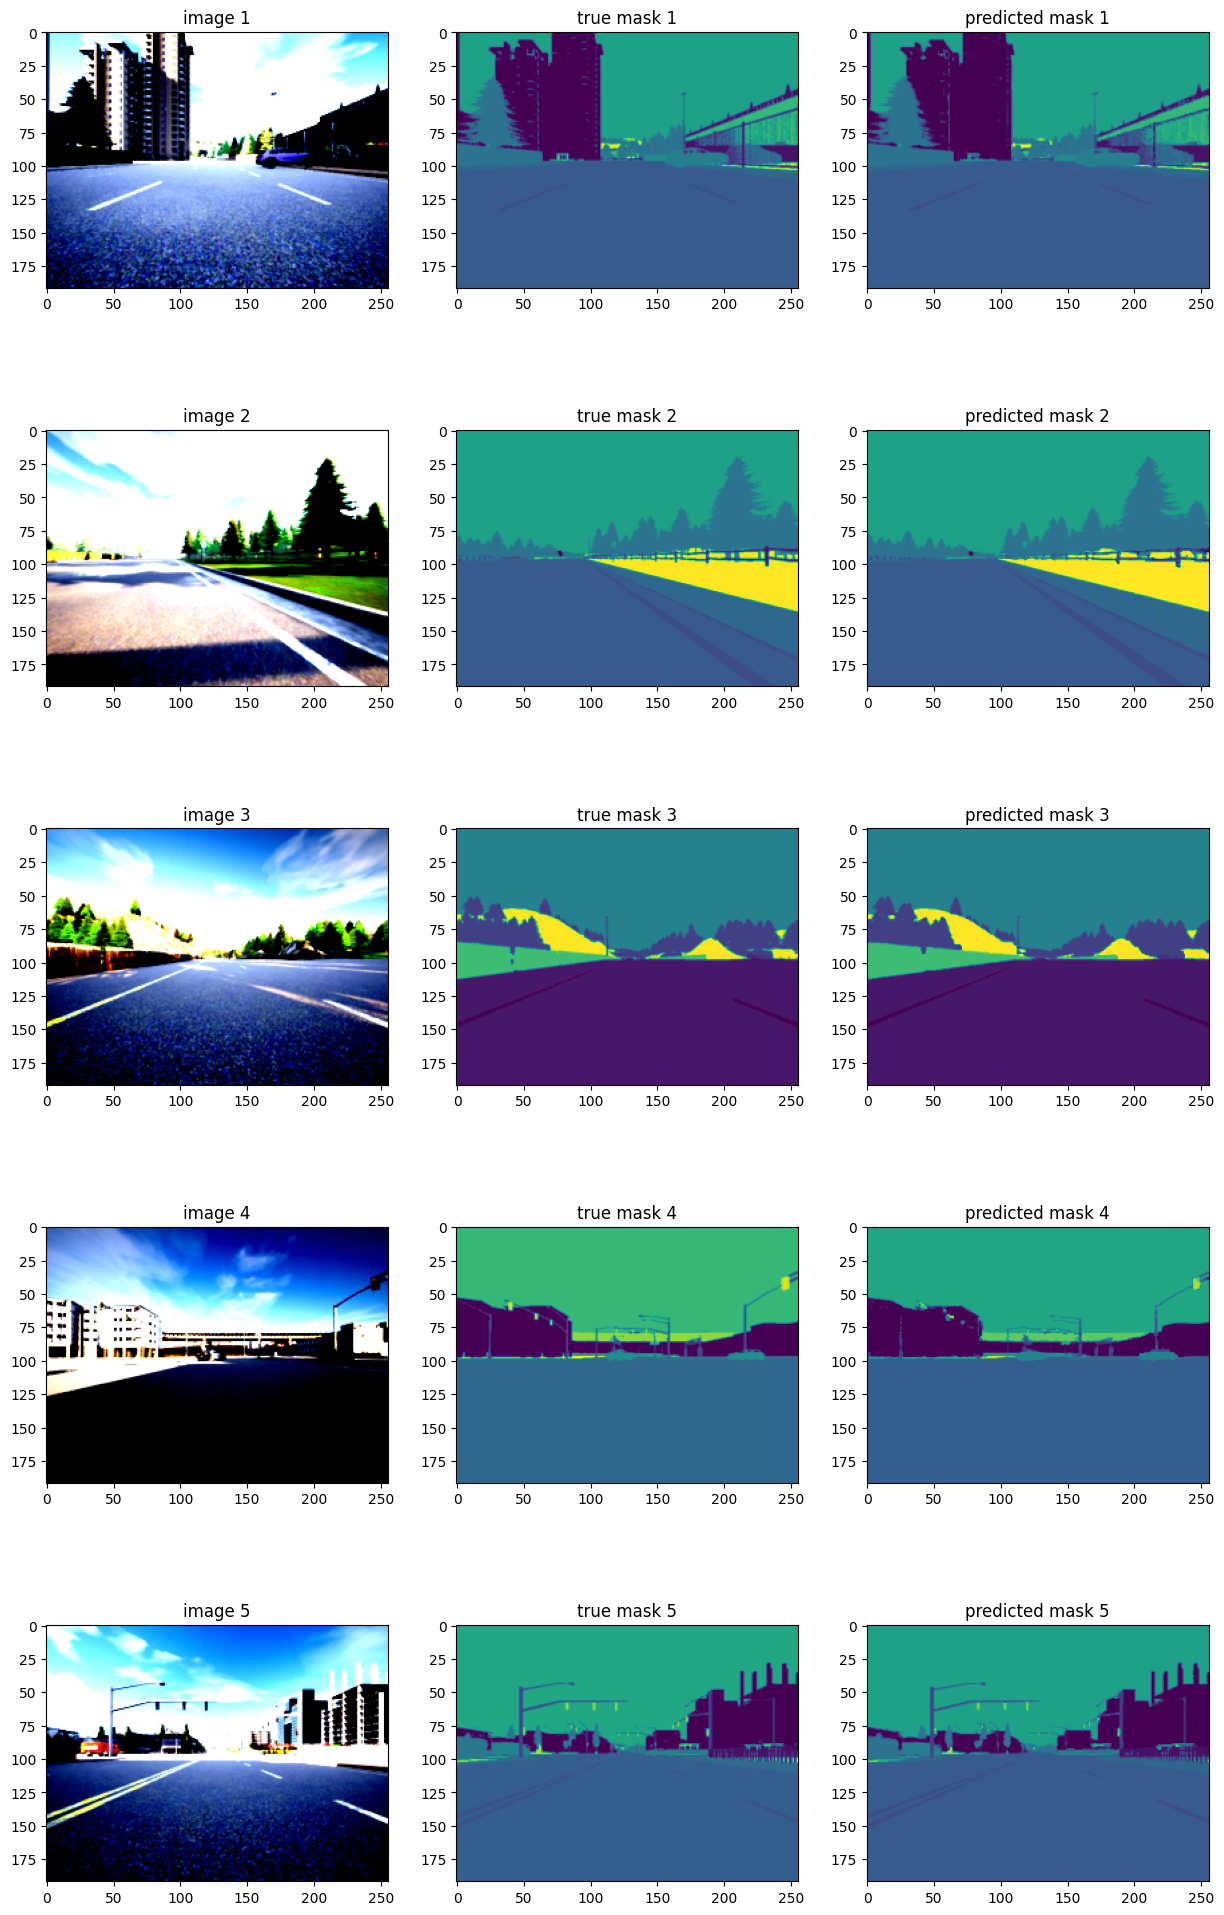

In [27]:
show_predictions(attention_unet, val_dataloader, device, 5)

## Compare mIoU of UNet and Attention-UNet on test data

In [28]:
def calculate_miou(y_true, y_pred, num_classes):
    y_true = y_true.flatten().cpu()
    y_pred = y_pred.flatten().cpu()

    miou = jaccard_score(y_true, y_pred, average='macro')
    return miou

In [29]:
unet_mious = []
attention_unet_mious = []

with torch.no_grad():
    for image, mask in test_dataloader:
        image = image.to(device)
        mask = mask.to(device)

        unet_mask_pred_prob = unet(image)
        attention_unet_mask_pred_prob = attention_unet(image)
        
        unet_mask_pred = create_mask(unet_mask_pred_prob)
        attention_unet_mask_pred = create_mask(attention_unet_mask_pred_prob)

        unet_mious.append(calculate_miou(mask, unet_mask_pred, 23))        
        attention_unet_mious.append(calculate_miou(mask, attention_unet_mask_pred, 23))

In [30]:
print(f'UNet mean IoU over test dataset: {np.mean(unet_mious)}')
print(f'Attention UNet mean IoU over test dataset: {np.mean(attention_unet_mious)}')

UNet mean IoU over test dataset: 0.4681953078210216
Attention UNet mean IoU over test dataset: 0.5406897147729257
